In [1]:
import torchvision.transforms as transforms

from datagen import DataGenerator
from torch.utils.data import DataLoader

from predict import *
from bbox import *
from constant import *
from models import Yolov1_vgg16bn

## Hyperparameter

In [2]:
validation_dataset = 'hw2_train_val/val1500'
pretrained_model_path = 'models/best_encurage_detection.pth'

data_size = 1500
num_batch = 16

img_size = 448
S = 7
B = 2
C = 16

hconf_threh = 0.1
nms_threh = 1

DEBUG = True

## Load Validation Data

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# validation dataset loader
validation_dataset = DataGenerator(
    parent_dir = validation_dataset, img_size = img_size,
    S = S, B=B, C = C, 
    transform=transform, num = data_size, train = False
)

validation_loader = DataLoader(validation_dataset, batch_size = num_batch, shuffle = False, num_workers = 2)

 500  1000  1500 

In [4]:
for key in validation_dataset.class_counting.keys():
    print(key,validation_dataset.class_counting[key])


ground-track-field 65
plane 1074
soccer-ball-field 68
container-crane 1
large-vehicle 2082
ship 3798
harbor 825
baseball-diamond 75
bridge 152
helicopter 26
tennis-court 340
roundabout 56
small-vehicle 13217
swimming-pool 152
storage-tank 765
basketball-court 52


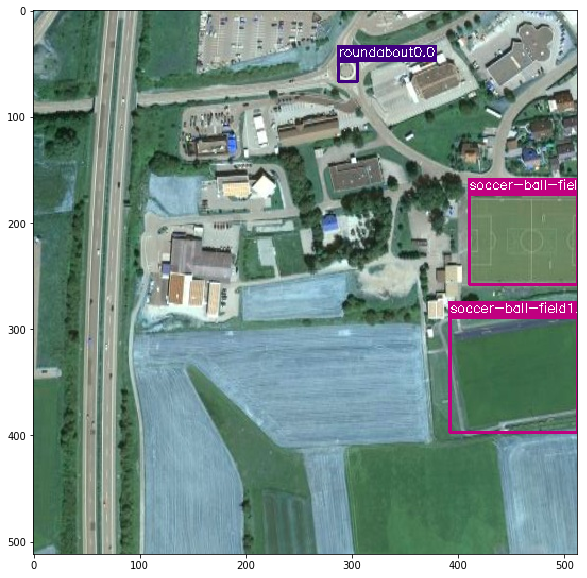

In [5]:
img_name, img, targets = validation_dataset.__getitem__(156)

dummy_example = targets

plt.figure(figsize=(10,10),facecolor='w') 
visualize_bbox_gt(img_name, train = False, img_size = 512)

In [6]:
idx = validation_dataset.image_names.index(img_name)
gt_bbox = validation_dataset.targets[idx]
print(gt_bbox.size())

conobj_mask = (targets[:,:,4] > 0).unsqueeze(-1).expand_as(targets)
conobj_bbox_train = targets[conobj_mask].view(-1,26)
print(conobj_bbox_train.size())

torch.Size([3, 5])
torch.Size([3, 26])


## Load Model

In [7]:
model = Yolov1_vgg16bn(pretrained = True)
model.load_state_dict(torch.load(pretrained_model_path))
model.eval()

if use_gpu:
    model.cuda()

FileNotFoundError: [Errno 2] No such file or directory: 'models/best_encurage_detection.pth'

## Predict One

**Processing after prediction**
1. bounding box(tensor): sized [98 ,4], [xmin, ymin, xmax, ymin]
2. class confidence(tensor): sized [98 ,1], max class prob * IoU confidence
3. max class probability(tensor): sized [98, 1]

In [ ]:
"""
Data processing
    1. bounding box(tensor): sized [98 ,4], [xmin, ymin, xmax, ymin]
    2. class confidence(tensor): sized [98 ,1], max class prob * IoU confidence
    3. class probability(tensor): sized [98, 16]
"""

pred_bbox_cxcy, cls_conf, max_cls_code= predict(img, model, DEBUG = DEBUG, dummy_example = dummy_example)

pred_bbox_xy = pred_bbox_revert(pred_bbox_cxcy)

In [ ]:
cls_conf_temp = cls_conf*9
torch.sort(cls_conf_temp, 0,descending = True)

## Filtering

1. filtering by class confidence
2. NMS

**Results**
1. high confidence bounding boxes_xy (tensor), sized [N, 4]: [xmin, ymin, xmax, ymax]
2. high confidence of class (tensor), sized [N, 1]
3. high confidence of class probability (tensor), sized [N, 16]

In [9]:
pred_bbox_xy

tensor([[  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,  73.1429,   0.0000,  73.1429],
        [  0.0000,  73.1429,   0.0000,  73.1429],
        [  0.0000, 146.2857,   0.0000, 146.2857],
        [  0.0000, 146.2857,   0.0000, 146.2857],
        [  0.0000, 219.4286,   0.0000, 219.4286],
        [  0.0000, 219.4286,   0.0000, 219.4286],
        [  0.0000, 292.5714,   0.0000, 292.5714],
        [  0.0000, 292.5714,   0.0000, 292.5714],
        [  0.0000, 365.7143,   0.0000, 365.7143],
        [  0.0000, 365.7143,   0.0000, 365.7143],
        [  0.0000, 438.8572,   0.0000, 438.8572],
        [  0.0000, 438.8572,   0.0000, 438.8572],
        [ 73.1429,   0.0000,  73.1429,   0.0000],
        [ 73.1429,   0.0000,  73.1429,   0.0000],
        [ 73.1429,  73.1429,  73.1429,  73.1429],
        [ 73.1429,  73.1429,  73.1429,  73.1429],
        [ 73.1429, 146.2857,  73.1429, 146.2857],
        [ 73.1429, 146.2857,  73.1429, 146.2857],


In [16]:
nms_threh = 0.1
hconf_threh = 0.1
bbox_xy_final,cls_conf_final,pred_cls_code_final = bbox_filtering(pred_bbox_xy, cls_conf, max_cls_code
                                                                  , nms_thresh = nms_threh, hconf_thresh = hconf_threh)

# class names
#max_cls_idx = torch.max(pred_cls_code_final, 1)[1].tolist() if pred_cls_code_final.size(0) != 0 else []
cls_labels = [DOTA_CLASSES[idx] for idx in pred_cls_code_final.squeeze(1).tolist()]


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [17]:
cls_labels

['roundabout', 'soccer-ball-field']

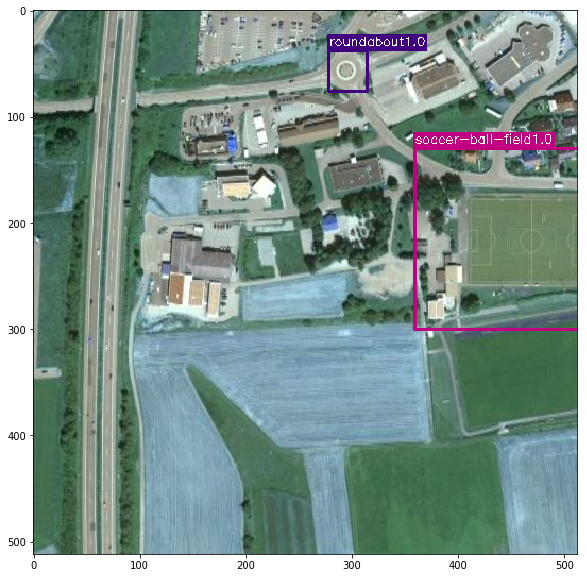

In [18]:
plt.figure(figsize=(10,10),facecolor='w')
visualize_bbox(img_name, bbox_xy_final.tolist(), cls_labels, cls_conf_final.tolist(), img_size = 512, train = False)